# W207.6 Final Project - Predicting Cancer Type from Tumor Mutations
## Notebook 1 - Data Collection
### Tony Di Sera, Vijay Singh, Rajiv Nair, Jeremey Fraenkel


[Presentation Slides](https://docs.google.com/presentation/d/13D6Pnyd9SEABHVPZ23TTqwttDFWkPKEHkD-C7crYJjg/edit?usp=sharing)

## Overview

In this project, we analyze the tumor mutation dataset from PanCancer Atlas Initiative https://www.cell.com/pb-assets/consortium/pancanceratlas/pancani3/index.html. This is a cancer dataset comprising over 10,000 patients diagnosed with cancer.  Overall, the study collected diverse and detailed molecular information on each patient's tumor, including DNA sequencing.

#### Primary Dataset
The primary dataset we will be using is the somatic mutations file. This file encodes whether or not a gene was found mutated in the biopsied tumor. In addition, we may pull some patient features like gender and age at diagnosis from the clinical patient file.

Number of Instances:  3,600,963 somatic mutations for 10,956 cancer patients
Number of Attributes:  ~100 attributes for mutations, ~700 clinical attributes for patients. We will aggregate the mutation data by gene for each patient, reducing the number of attributes by patient to ~ 500-1000 features.

#### Background
By comparing the DNA from normal tissue cells to those of the cancerous cells, somatic mutations can be identified and characterized. Somatic mutations are non-inherited variations to the DNA of a cell that arise during an individual's lifetime. We will use these DNA mutations to predict cancer type, classified into 33 different tissue/organ types. These different cancer types represent the 33 most prevelent cancers in the general population.  As such, the 10,000 sample tumors sequenced are distributed across the 33 cancer types in approximately the same proportions as expected in the population.

#### Motivation
There is clinical value in being able to predict cancer type based on molecular profiles.  For some patients diagnosed with cancer, the biopsied tumor doesn't match the histologic characteristics of the organ/tissue site.  For example, a patient may have a liver tumor that cannot be characterized as liver cells when reviewed by the pathologist.  In these cases, the cancer may have originated from another site and has metastasized to the liver.  This is where genomic tumor data may provide insights by predicting the 'cell of origin', leading to a better-suited therapy for the patient.


## Initialization

In [0]:
import pandas as pd
import urllib.request
import numpy as np
import glob
import os
import warnings
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn import preprocessing
from IPython.core.interactiveshell import InteractiveShell
from sklearn.model_selection import train_test_split

InteractiveShell.ast_node_interactivity = "all"
plt.rcParams.update({'figure.max_open_warning': 0})

# Establish the colors for each cancer type
label_colors = []
cm = plt.get_cmap('tab20b')
for i in range(20):
    label_colors.append(cm(i))
cm = plt.get_cmap('tab20c')
for i in range(13):
    label_colors.append(cm(i))

In [0]:
# create the directory where the downloaded directory is stored
data_dir = "./data"
if not os.path.isdir(data_dir):
    os.makedirs(data_dir)
    
# create the directory where the metrics are stored
metrics_dir = "./metrics"
if not os.path.isdir(metrics_dir):
    os.makedirs(metrics_dir)
    
# create the raw where the source data is stored
raw_dir = "./raw"
if not os.path.isdir(raw_dir):
    os.makedirs(raw_dir)    

In [0]:
# This downloads a dictionary file
dictionary_filename = "./raw/tcga_dictionaries.txt"
if os.path.isfile(dictionary_filename):
    print("Skipping download, as file %s is present" %(dictionary_filename))
else:
    print('Downloading dictionary file...')
    url = 'https://w207-final-project.s3.amazonaws.com/raw/tcga_dictionaries.txt'  
    urllib.request.urlretrieve(url, dictionary_filename)  
print("done.")


# This loads the data dictionary to will convert
# the tumor_sample_barcode into a cancer_type
# and provide full names for the cancer types
tcga_dict = open("./raw/tcga_dictionaries.txt","r")
dict_name_index = 0 #Set dictionary index counter to 0
for line in tcga_dict:
    if line.startswith("#"): #If line starts with #, the next line will be a known dictionary
        dict_name_index += 1
    elif dict_name_index == 4:
        tissue_source_site = eval(line)            
    elif dict_name_index == 5:
        code_to_disease = eval(line)
    elif dict_name_index == 6:
        disease_to_code = eval(line)

Skipping download, as file ./raw/tcga_dictionaries.txt is present
done.


## Download the data 
For our analysis of cancer prediction using gene mutation and clinical data from patients, we will gather data from multiple sources. First we obtain the somatic mutation data from the PanCancerAtlas website (https://gdc.cancer.gov/about-data/publications/pancanatlas). We also download the patient clinical data that corresponds to the tumor data. At this time, we are not bringing in clinical features, but as the project progresses, we would like to bring in a few features from this clinical dataset (e.g. age a diagnosis, gender). In our notebook, we store this data locally so that it does not have to be downloaded if the notebook kernel is restarted and run multiple times.

In [0]:
# to make this notebook's output stable across runs
np.random.seed(42)

### Download the somatic mutations file
This file is in the 'MAF' file format, a bioinformatics tab separated format that can contains one record
for each mutation observed in a patient tumor sample.

In [0]:
# This downloads a 753 MB somatic mutations gzip file.  
# This will take about 1-5 mins depending on your
# connection speed.
mutations_filename = "./data/somatic_mutations.maf.gz"
if os.path.isfile(mutations_filename):
    print("Skipping download, as file %s is present" %(mutations_filename))
else:
    print('Downloading mutation data. 753 MB (may take a few minutes)...')
    url = 'http://api.gdc.cancer.gov/data/1c8cfe5f-e52d-41ba-94da-f15ea1337efc'  
    urllib.request.urlretrieve(url, mutations_filename)  
print("done.")

('./data/somatic_mutations.maf.gz',
 <http.client.HTTPMessage at 0x7f11a4735b38>)

done.


### Download the patient clinical data

In [0]:
# This downloads an 18 MB patient clinical data file
patient_filename = "./data/patient_clinical_data.txt"
if os.path.isfile(patient_filename):
    print("Skipping download, as file %s is present" %(patient_filename))
else:
    print('Downloading clinical data ...')  
    url = 'http://api.gdc.cancer.gov/data/0fc78496-818b-4896-bd83-52db1f533c5c'
    urllib.request.urlretrieve(url, patient_filename)  
print("done.")

('./data/patient_clinical_data.txt',
 <http.client.HTTPMessage at 0x7f11a47392e8>)

done.


## Loading Gene Mutation Data ##

Here we read the gene mutation data. This data file contains many columns, but after careful curation, we have decided to consider the following colums:

1. **tumor_sample_barcode**: this contains the barcode with the first 12 characters identifying the patient
2. **gene**: this is the actual gene that has been mutated (for e.g. TACC2, JAKMIP3, PANX3)
3. **gene_type**: this indicates if the gene is protein coding or not.
4. **chromosome**  **start** **end** **Strand**: the chromosome, start position and end position tells us the location of the gene where the mutation is seen.  Strand indicates if it is on the forward or reverse strand of the DNA.
5. **variant_type**: this indicates if it is a single substitution mutation (SNP), a small deletion (DEL), or small insertion (INS), two nucleotide substitution (DNP), three nucleotide substitution (TNP), or more that three nucleotide substitution (ONP)
6. **variant_classification**: this indicates what kind of molecular effect that this mutation will have on the protein.  The most common classes indicate if the substitution causes a change to the amino acid (missense vs silent).  Nonsense mutations cause premature termination of the protein; frameshift mutations cause a misreading of the amino acid sequence.
7. **variant_impact**: this indicates how damaging the mutation -- HIGH, MODERATE, MODIFIER, or LOW.


In [0]:
# Load the mutations dataframe
print('Loading mutations dataframe ...')

mutations = pd.read_csv(mutations_filename, compression='gzip',
                        sep='\t',
                        usecols=['Tumor_Sample_Barcode','Hugo_Symbol', 'BIOTYPE',
                                'Chromosome', 'Start_Position',  'End_Position', 'Strand',
                                'Variant_Type',  'Variant_Classification', 'IMPACT' ])

print("done.")

# Set mutations index
mutations['row'] = np.arange(len(mutations))
mutations.set_index('row', inplace=True)

# Rename the columns to more consistent names
renamed_columns = { 'Tumor_Sample_Barcode': 'tumor_sample_barcode', 
                    'Hugo_Symbol': 'gene', 
                    'BIOTYPE': 'gene_type', 
                    'Chromosome': 'chromosome', 
                    'Start_Position': 'start', 
                    'End_Position': 'end', 
                    'Strand': 'strand', 
                    'Variant_Type': 'variant_type', 
                    'Variant_Classification': 'variant_classification', 
                    'IMPACT': 'variant_impact'}
mutations.rename(renamed_columns, inplace=True, axis=1)

print("\nMutations count:       ", mutations.tumor_sample_barcode.count())
print("Number of unique samples:", mutations.tumor_sample_barcode.nunique())

Loading mutations dataframe ...


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


done.

Mutations count:        3600963
Number of unique samples: 10295


In [0]:
mutations.head()

,gene,chromosome,start,end,strand,variant_classification,variant_type,tumor_sample_barcode,gene_type,variant_impact
row,,,,,,,,,,
0,TACC2,10,123810032,123810032,+,Missense_Mutation,SNP,TCGA-02-0003-01A-01D-1490-08,protein_coding,MODERATE
1,JAKMIP3,10,133967449,133967449,+,Silent,SNP,TCGA-02-0003-01A-01D-1490-08,protein_coding,LOW
2,PANX3,11,124489539,124489539,+,Missense_Mutation,SNP,TCGA-02-0003-01A-01D-1490-08,protein_coding,MODERATE
3,SPI1,11,47380512,47380512,+,Missense_Mutation,SNP,TCGA-02-0003-01A-01D-1490-08,protein_coding,MODERATE
4,NAALAD2,11,89868837,89868837,+,Missense_Mutation,SNP,TCGA-02-0003-01A-01D-1490-08,protein_coding,MODERATE


The actual cancer type can be found by parsing the tumor sample barcode and then looking up
the cancer type code in the dictionary based on the tissue source site portion of the
tumor sample barcode. For e.g., the *tumor_sample_barcode* 'TCGA-ZX-AA5X-01A-11D-A42O-09' will be parsed into the *tissue source site* **ZX** that is then mapped using the tissue cancer dictionary to *Cervical_squamous_cell_carcinoma_and_endocervical_adenocarcinoma* or *CESC*.

In [0]:
# Parse the tissue source site from the tumor sample barcode.  Then use the
# tissue site source to lookup the cancer type from the tcga_dictionaries
def parse_cancer_type(tumor_sample_barcode):
    tss = tumor_sample_barcode.split("-")[1] #Extra the tissue source site from the tcga_id
    cancer_type = disease_to_code[tissue_source_site[tss][1]][0] #Convert from tss to disease to code 
    return cancer_type


mutations['cancer_type'] = mutations['tumor_sample_barcode'].apply(parse_cancer_type)
print("Number of unique cancer types:", mutations.cancer_type.nunique())


# Get the patient barcode.  This is what we will use to join the mutations to the clinical data
def parse_patient_barcode(tumor_sample_barcode):
        return tumor_sample_barcode[0:12]

mutations['patient_barcode'] = mutations['tumor_sample_barcode'].apply(parse_patient_barcode)
#mutations = mutations.drop(['tumor_sample_barcode'], axis=1)
#mutations = mutations.drop(['cancer_type'], axis=1)
print("Number of unique patients:", mutations['patient_barcode'].nunique())

Number of unique cancer types: 33
Number of unique patients: 10224


## Loading Patient Data##

Here we load the clinical data. This is data for patients for whom we collected the gene mutation data above. The patients are identified by $patient\_barcode$. We will use this field to populate the gene mutation data from the dataframe above in the table we are about to read. The clinical data has patient information such as gender and age at diagnosis.

In [0]:
# Load the clinical data
print('Loading clinical dataframe ...')
clinical = pd.read_csv(patient_filename, sep='\t',
                        usecols=['bcr_patient_barcode', 'acronym', 'gender', 
                                 'age_at_initial_pathologic_diagnosis'])

# Rename the columns to more consistent names
renamed_columns = { 'bcr_patient_barcode': 'patient_barcode', 
                    'acronym': 'cancer_type' }
clinical.rename(renamed_columns, inplace=True, axis=1)

print('Clinical count', clinical.patient_barcode.count())

# Get cancer types
cancer_types = clinical['cancer_type'].unique()
print("\nNumber of cancer types", len(cancer_types))

Loading clinical dataframe ...
Clinical count 10956

Number of cancer types 32


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Plot number of examples per cancer type

Number of patients 10956


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_core.py:185: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


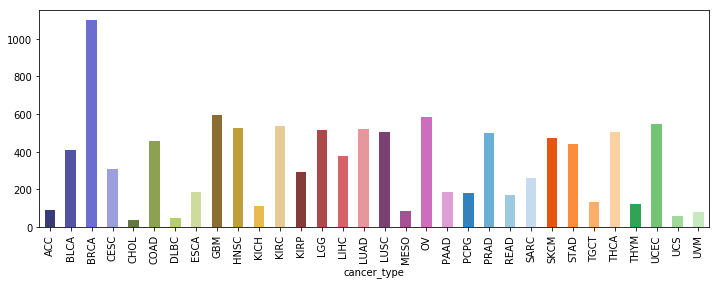

In [0]:
# Get number of cases per cancer type
group_by_patient = clinical.groupby(['cancer_type'])['patient_barcode'].nunique()
print("Number of patients", group_by_patient.sum())
group_by_patient.plot.bar(figsize=(12,4), colors=label_colors)

In the above histogram, we can already see a challenge that we will be faced with in this work. While some cancers such as BRCA (Breast Cancer) have a large number of cases represented in the dataset, other such as Uterine Carcinosarcoma (UCS) have very few cases. We will pay special attention to the robustness of our classifiers in being able to classify the rarer cases with high accuracy as well.

## Creating Merged Data ##

Now that we have both gene and cancer data in one dataframe, and the patient clinical data in another dataframe, we will use the **patient_barcode** to merge these into a single table. With this, we can drop the tumor_sample_barcode column, since it has served its purpose. Looking at the data, it seems like some patient data is missing from the gene data. Simultaneously, some data in the gene dataframe does not have corresponding clinical data. Hence our merged dataframe size will be lower than the original mutations dataframe size.

In [0]:
clinical['patient_barcode'].isnull().values.any()

False

In [0]:
gene_barcode_set = set(mutations.patient_barcode.unique())
patient_barcode_set = set(clinical.patient_barcode.unique())
print("%d patients with gene data missing in clinical data"% len(gene_barcode_set - patient_barcode_set))

216 patients with gene data missing in clinical data


In [0]:
# perform the merge
merged = mutations.merge(clinical, left_on='patient_barcode', right_on='patient_barcode')
print('Merged mutations count:   ', merged.patient_barcode.count())
print('Number of unique patients:', merged.patient_barcode.nunique())
merged.rename({'cancer_type_x': 'cancer_type'}, axis=1, inplace=True)
print('Number of cancer types:   ', merged.cancer_type.nunique())

Merged mutations count:    3570876
Number of unique patients: 10008
Number of cancer types:    32


In [0]:
# store the merged data, and the mutations data into csv format
fileName = "./data/mutations_with_clinical.csv"
print("  writing", fileName, "...")
merged.to_csv(fileName)
print("  done.")

fileName = "./data/mutations.csv"
print("  writing", fileName, "...")
mutations.to_csv(fileName)
print("  done.")

  writing ./data/mutations_with_clinical.csv ...
  done.
  writing ./data/mutations.csv ...
  done.


## Eliminate any psuedo-genes. 

This is a common filter in bioinformatics analysis, eliminating pseudo-genes.  These are imperfect copies of functional genes.

In [0]:
psuedo_genes = list(['transcribed_unprocessed_pseudogene',
               'polymorphic_pseudogene', 
               'unprocessed_pseudogene', 
               'transcribed_processed_pseudogene', 'processed_pseudogene',
               'pseudogene', 'unitary_pseudogene'])
ps_genes = mutations[mutations.gene_type.isin(psuedo_genes)].gene.unique()

In [0]:
# show some examples of psedu-genes that are removed
ps_genes[0:20]

array(['POTEA', 'SDHAP2', 'SSX9', 'PSG10P', 'PSG7', 'PLGLA', 'TUBBP5',
       'BCRP7', 'TREML3P', 'TRIM51HP', 'CTC-260E6.2', 'C3P1',
       'ANKRD20A5P', 'CYP4Z2P', 'RP1-164F3.8', 'SVILP1', 'ADH1C', 'OR2W5',
       'FUNDC2P2', 'PPP1R2P4'], dtype=object)

In [0]:
# Eliminate psuedo genes
before_count               = mutations.gene.nunique()
mutations_coding           = mutations[~mutations.gene_type.isin(psuedo_genes)]
after_count                = mutations_coding.gene.nunique()
print("Filtered out ", str(before_count - after_count), "genes")
mutations                  = mutations_coding

Filtered out  129 genes


## Split the data into training and test datasets
Split the data into a training and test split.  We will use a split of 80% training, 20% test.  
We will split based on the patient_barcode.  As part of feature engineering, we will be 
aggregating mutations, so that each example will be represented as a patient (tumor), with
columns for each gene.

In [0]:
#
# Split the patients into training and test
#
def split_patient_data(data):
    patient_data = data.patient_barcode.unique()

    le     = preprocessing.LabelEncoder()
    patient_labels_string = data.groupby('patient_barcode')['cancer_type'].nunique()
    patient_labels = le.fit_transform(patient_labels_string)
    
    print("Number of unique patients:           ", patient_data.shape[0])
    print("Number of labels for unique patients:", len(patient_labels))
    
    train_data, test_data, train_labels, test_labels = train_test_split(
                                                               patient_data, patient_labels,
                                                               stratify=patient_labels, 
                                                               test_size=0.20)

    print("\ntraining patients:  ", train_data.shape[0])
    print("test patients:      ", test_data.shape[0])
    return {'train_patients': train_data, 'test_patients': test_data}

In [0]:
#
#  Split Mutations data (based on patient split) and 
#  write out data files
#
def split_and_save_mutation_data(split):   
    train_patients = split['train_patients']
    test_patients  = split['test_patients']

    train_mutations = mutations[mutations.patient_barcode.isin(train_patients)]
    test_mutations  = mutations[mutations.patient_barcode.isin(test_patients)]
    print("\ntraining data:      ", train_mutations.shape[0])
    print("test data:          ", test_mutations.shape[0])
    print("\nall data:           ", test_mutations.shape[0])
    print("train + test:       ", test_mutations.shape[0] + test_mutations.shape[0])
    
    # Write out mutations training data as csv file
    print("\nWriting training set ...")
    train_mutations.to_csv("./data/somatic_mutations_train.csv")
    print("done.")

    # Write out mutations test data as csv file
    print("\nWriting test set ...")
    test_mutations.to_csv("./data/somatic_mutations_test.csv")
    print("done.")

split = split_patient_data(mutations)   
split_and_save_mutation_data(split)

Number of unique patients:            10224
Number of labels for unique patients: 10224

training patients:   8179
test patients:       2045

training data:       2820587
test data:           773193

all data:            773193
train + test:        1546386

Writing training set ...
done.

Writing test set ...
done.
